In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings; warnings.simplefilter('ignore')  # For demonstration purposes only

sns.set(font_scale=1.5)
sns.set_style('ticks')

# Proposal for a multiple regression noise ceiling

## The problem

I recently wrote a tutorial describing the [noise ceiling for correlation analysis](noise_ceiling_tutorial.ipynb). The noise ceiling quantifies the amount of measurement error in the data as a point of comparison for statistical models. Cool and useful as this is, the univariate, correlational method described in the tutorial falls apart for more complicated analyses, such as multiple regression.

This is because in multiple regression we assume there are more sources of variance than measurement noise alone. For example, participants might vary in their sensitivity to different stimulus features, which may affect their responses. A univariate correlation analysis treats these differences as noise, but a multiple regression analysis can take them into account by including a predictor for each stimulus feature. For this reason, multiple regression can explain variance in excess of the univariate, correlational noise ceiling. There is a further problem: model evaluation measures like $R^2$ aren't directly comparable to correlation coefficients.

## The solution

This notebook proposes a noise ceiling for multiple regression. The noise ceiling depends on the idea of the "best model." For correlation, the best model of the data is the mean of all the samples. Because this model is produced _from_ the data—through maximal overfitting—no model could have a higher correlation _with_ the data. Here, I propose that the "best model" of the data in multiple regression is the set of predictors derived from the data that accounts for as much of the variance as possible. 

To find these predictors, we use [principal components analysis](http://setosa.io/ev/principal-component-analysis/) (PCA), which is defined to perfectly fit our needs. If our multiple regression analysis has $n$ predictors, we run PCA to find $n$ components. In addition to these components, we include the sample mean of the data (as in the univariate noise ceiling). This compensates for the origin shift in PCA and the intercept of our multiple regression. We then use these predictors in a multiple regression (without fitting an intercept—the sample mean predictor takes care of that) to find the noise ceiling for $R^2$.

## An imaginary multivariate experiment

Imagine we are conducting an experiment to see how much people with different personality traits enjoy different activities, like skiing, cooking, doing homework, and so on. It turns out that people high in conscientiousness like some activities and dislike others, and people high in extraversion like and dislike a different set of activities. Further, conscientiousness and extraversion vary independently from one another. 

Before we proceed, a brief note on visualization. This uses heatmaps instead of line plots to encourage thinking about analyzing data as performing operations on features-by-samples arrays.

Our (totally made up) true model looks like this:

In [2]:
trait_a_true = np.hstack([np.linspace(-1, 1, 10), np.linspace(1, -1, 40)])
trait_b_true = np.hstack([np.linspace(-1, 1, 40), np.linspace(1, -1, 10)])
trait_vectors = np.array([trait_a_true, trait_b_true])

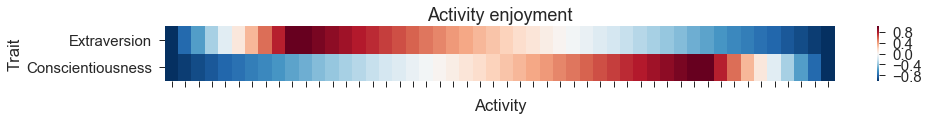

In [3]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(trait_vectors)
plt.title("Activity enjoyment")
plt.xlabel("Activity")
plt.ylabel("Trait")
ax.set_yticklabels(['Conscientiousness', 'Extraversion'])
ax.set_xticklabels([''] * len(trait_a_true))
plt.yticks(rotation=0);

Because participants can have either of these traits to varying degrees, a single participant's response is a linear combination of these vectors with random trait coefficients, plus noise:

In [4]:
def create_participant(trait_vectors, noise_mean=0, noise_sd=.25):
    trait_coefs = np.random.random(trait_vectors.shape[0])
    responses = np.sum(trait_coefs[:, np.newaxis] * trait_vectors, axis=0)
    noise = np.random.normal(size=trait_vectors.shape[1], loc=noise_mean, scale=noise_sd)
    return responses + noise, trait_coefs

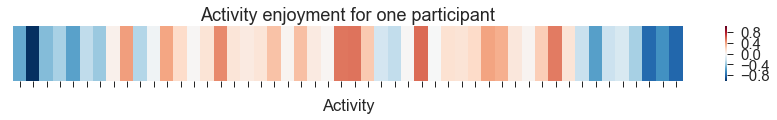

In [5]:
p, coefs = create_participant(trait_vectors, noise_mean=0, noise_sd=.25)

fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(p[np.newaxis, :])
plt.title("Activity enjoyment for one participant")
plt.xlabel("Activity")
plt.yticks([])
ax.set_xticklabels([''] * len(trait_a_true));

Let's create a population of simulated participants.

In [6]:
def create_population(n, trait_vectors, noise_mean=0, noise_sd=.25):
    participants = list()
    trait_coefs = list()
    for _ in range(n):
        p, c = create_participant(trait_vectors, noise_mean, noise_sd)
        participants.append(p)
        trait_coefs.append(c)
    return np.array(participants), np.array(trait_coefs)

We generate our simulated population and store the trait coefficients for later testing.

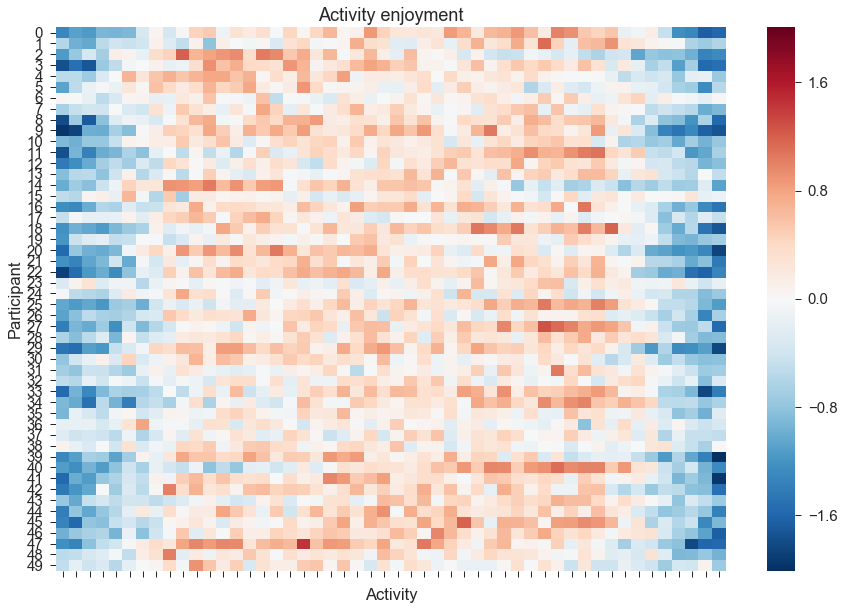

In [7]:
participants, trait_coefs = create_population(50, trait_vectors, noise_mean=0, noise_sd=.25)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(participants)
plt.title("Activity enjoyment")
plt.xlabel("Activity")
plt.ylabel("Participant")
ax.set_xticklabels([''] * len(trait_a_true))
plt.yticks(rotation=0);

We run the regression on each participant, estimating the coefficient for each trait...

In [8]:
from sklearn.linear_model import LinearRegression

def test_participants(model_vectors, participants):
    model_coefs = list()
    model_r2s = list()
    for participant in participants:
        model = LinearRegression(fit_intercept=True)
        model.fit(model_vectors.T, participant)
        model_coefs.append(model.coef_)
        model_r2s.append(model.score(model_vectors.T, participant))
    return model_coefs, model_r2s

In [9]:
model_coefs, model_r2s = test_participants(trait_vectors, participants)

And then evaluate our model.

In [10]:
print(f"R^2 = {np.mean(model_r2s).round(2)}")

R^2 = 0.69


## Calculating the multivariate noise ceiling

But how good is our model, really? If we didn't know in advance that this is the true model, we would want to calculate a noise ceiling. Here we implement the PCA-based method described in the introduction.

In [11]:
def multivariate_noise_ceiling(data, n_predictors):
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    
    # Upper bound
    sample_mean = data.mean(axis=0)
    reduce = PCA(n_components=n_predictors)
    reduce.fit(data)
    best_predictors = np.vstack([reduce.components_, sample_mean])
    
    ub_scores = list()
    for sample in data:
        model = LinearRegression(fit_intercept=False)
        model.fit(best_predictors.T, sample)
        ub_scores.append(model.score(best_predictors.T, sample))
        
    # Lower bound, LOO procedure
    lb_scores = list()
    for i in range(data.shape[0]):
        data_i = data[i]
        data_loo_ix = np.repeat([True], data.shape[0])
        data_loo_ix[i] = False
        data_loo = data[data_loo_ix]
        sample_mean_loo = data_loo.mean(axis=0)
        
        reduce_loo = PCA(n_components=n_predictors)
        reduce_loo.fit(data_loo)
        best_predictors_loo = np.vstack([reduce_loo.components_, sample_mean_loo])
        model_loo = LinearRegression(fit_intercept=False)
        model_loo.fit(best_predictors_loo.T, data_i)
        lb_scores.append(model_loo.score(best_predictors_loo.T, data_i))
    
    return np.mean(lb_scores), np.mean(ub_scores)

In [12]:
lower_bound, upper_bound = multivariate_noise_ceiling(participants, 2)
print(f"R^2 = {np.mean(model_r2s).round(3)}")
print(f"Lower bound: {np.round(lower_bound, 3)}")
print(f"Upper bound: {np.round(upper_bound, 3)}")

R^2 = 0.688
Lower bound: 0.682
Upper bound: 0.713


The true model lands within the bounds of the noise ceiling.

## Different levels of noise

Does the multivariate noise ceiling behave appropriately, regardless of the amount of noise?

In [13]:
def simulate(true_model, test_model, n_participants, noise_sd):
    participants, _ = create_population(
        n_participants, true_model, noise_mean=0, noise_sd=noise_sd
    )
    _, model_r2s = test_participants(test_model, participants)
    lower_bound, upper_bound = multivariate_noise_ceiling(participants, test_model.shape[0])
    return model_r2s, lower_bound, upper_bound

In [14]:
noise_sds = np.linspace(0, 2, 11)
noise_sds[0] = .01
n_participants = 50
noise_sd = .5
n_simulations = 100

rows_noise = list()
below_lower_noise = list()
above_upper_noise = list()
for noise_sd in noise_sds:
    below_lower_loop = list()
    above_upper_loop = list()
    for _ in range(n_simulations):
        model_r2s, lower_bound, upper_bound = simulate(
            true_model=trait_vectors, 
            test_model=trait_vectors, 
            n_participants=n_participants, 
            noise_sd=noise_sd
        )
        rows_noise.append([noise_sd, np.mean(model_r2s), 'Mean R2'])
        rows_noise.append([noise_sd, lower_bound, 'Lower bound'])
        rows_noise.append([noise_sd, upper_bound, 'Upper bound'])
        below_lower_loop.append(np.mean(model_r2s) < lower_bound)
        above_upper_loop.append(np.mean(model_r2s) > upper_bound)
    below_lower_noise.append(below_lower_loop)
    above_upper_noise.append(above_upper_loop)

df_noise = pd.DataFrame(
    rows_noise, 
    columns=['Noise SD', 'Value', 'Value type']
)

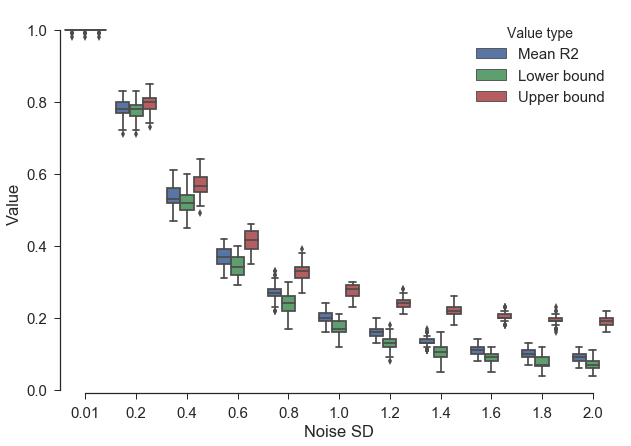

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='Noise SD', y='Value', hue='Value type', data=df_noise.round(2))
sns.despine(trim=True)

With no noise, model performance and the noise ceiling are maxed out. As noise increases, the noise ceiling drops along with model performance. The true result tends to stay within the bounds of the noise ceiling, except when the noise levels are very low or very high.

In [16]:
print("Proportion of results outside bounds at each noise level:")
print(f"Below lower bound: {np.mean(below_lower_noise, axis=1).round(2)}")
print(f"Above upper bound: {np.mean(above_upper_noise, axis=1)}")

Proportion of results outside bounds at each noise level:
Below lower bound: [0.13 0.01 0.   0.   0.   0.   0.   0.   0.   0.03 0.08]
Above upper bound: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Different sample sizes

Does the multivariate noise ceiling behave appropriately at different sample sizes?

In [17]:
sample_sizes = np.array([10, 20, 40, 80, 160, 320, 640])
n_participants = 50
noise_sd = .5
n_simulations = 100

rows_n = list()
below_lower_n = list()
above_upper_n = list()
for n_participants in sample_sizes:
    below_lower_loop = list()
    above_upper_loop = list()
    for _ in range(n_simulations):
        model_r2s, lower_bound, upper_bound = simulate(
            true_model=trait_vectors, 
            test_model=trait_vectors, 
            n_participants=n_participants, 
            noise_sd=noise_sd
        )
        rows_n.append([n_participants, np.mean(model_r2s), 'Mean R2'])
        rows_n.append([n_participants, lower_bound, 'Lower bound'])
        rows_n.append([n_participants, upper_bound, 'Upper bound'])
        below_lower_loop.append(np.mean(model_r2s) < lower_bound)
        above_upper_loop.append(np.mean(model_r2s) > upper_bound)
    below_lower_n.append(below_lower_loop)
    above_upper_n.append(above_upper_loop)

df_n = pd.DataFrame(
    rows_n, 
    columns=['Sample size', 'Value', 'Value type']
)

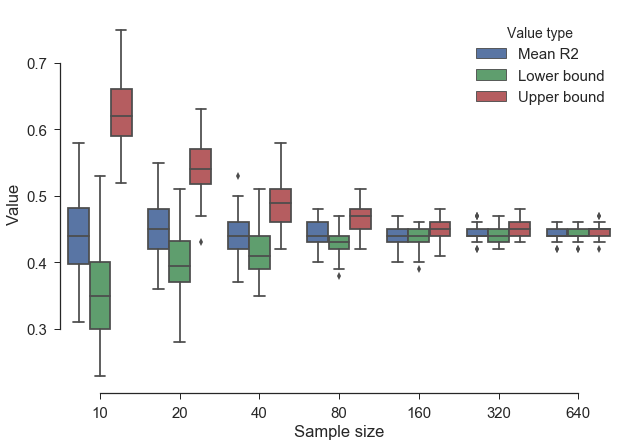

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='Sample size', y='Value', hue='Value type', data=df_n.round(2))
sns.despine(trim=True)

As the sample size increases the upper bound drops, appearing to converge with the true model. The performance of the true model falls within the bounds of the noise ceiling, except sometimes (< 5% of the time) at large sample sizes where the range of the noise ceiling is very small.

In [19]:
print("Proportion of results outside bounds at each sample size:")
print(f"Below lower bound: {np.mean(below_lower_n, axis=1).round(2)}")
print(f"Above upper bound: {np.mean(above_upper_n, axis=1)}")

Proportion of results outside bounds at each sample size:
Below lower bound: [0.   0.   0.   0.   0.01 0.04 0.03]
Above upper bound: [0. 0. 0. 0. 0. 0. 0.]


## Different numbers of predictors

A known issue with multivariate regression is that adding additional predictors allows the model to overfit increasing amounts of measurement noise. Does the multivariate noise ceiling behave appropriately (i.e., does it also inflate) as the number of predictors increases?

In [20]:
def gen_predictors(shape):
    predictors = np.random.random(shape)
    return (predictors - predictors.mean()) / predictors.std() 

In [21]:
predictor_counts = np.linspace(2, 50, 13).astype(int)
n_features = 50

n_participants = 50
noise_sd = .5
n_simulations = 100

rows_pred = list()
below_lower_pred = list()
above_upper_pred = list()
for predictor_count in predictor_counts:
    below_lower_loop = list()
    above_upper_loop = list()
    for _ in range(n_simulations):
        predictors = gen_predictors((predictor_count, n_features))
        model_r2s, lower_bound, upper_bound = simulate(
            true_model=predictors, 
            test_model=predictors, 
            n_participants=n_participants, 
            noise_sd=noise_sd
        )
        rows_pred.append([predictor_count, np.mean(model_r2s), 'Mean R2'])
        rows_pred.append([predictor_count, lower_bound, 'Lower bound'])
        rows_pred.append([predictor_count, upper_bound, 'Upper bound'])
        below_lower_loop.append(np.mean(model_r2s) < lower_bound)
        above_upper_loop.append(np.mean(model_r2s) > upper_bound)
    below_lower_pred.append(below_lower_loop)
    above_upper_pred.append(above_upper_loop)

df_pred = pd.DataFrame(
    rows_pred, 
    columns=['Predictor count', 'Value', 'Value type']
)

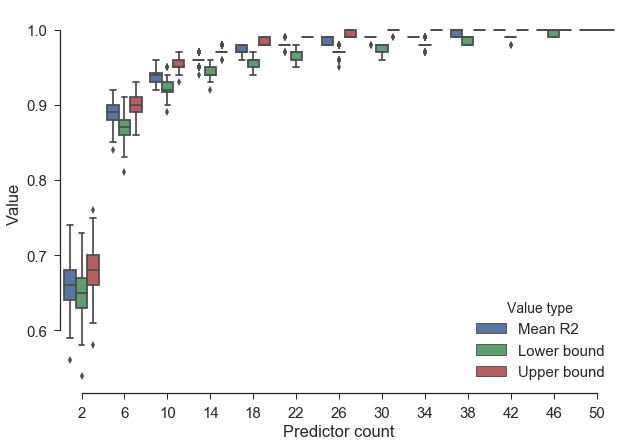

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='Predictor count', y='Value', hue='Value type', data=df_pred.round(2))
sns.despine(trim=True)

As the predictor count increases, so do model performance and the noise ceiling. The true model performance stays within the noise ceiling.

In [23]:
print("Proportion of results outside bounds at each predictor count:")
print(f"Below lower bound: {np.mean(below_lower_pred, axis=1).round(2)}")
print(f"Above upper bound: {np.mean(above_upper_pred, axis=1)}")

Proportion of results outside bounds at each predictor count:
Below lower bound: [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Above upper bound: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## For multiple measurements of a single participant

Here we confirm that the multivariate noise ceiling provides results similar to the univariate noise ceiling when all of the variance in the data is due to measurement error.

In [24]:
def univariate_noise_ceiling(data):
    """Calculate the lower and upper bounds of the noise ceiling.
    
    Args:
        data (numpy.array): Your data, samples-by-features.
    """
    from scipy.stats import pearsonr
    
    best_fit = data.mean(axis=0)
    sample_fits = np.array([pearsonr(best_fit, sample)[0] for sample in data])
    upper_bound = sample_fits.mean()
    
    correlations = list()
    for i in range(data.shape[0]):
        sample_left_out = data[i]
        left_in_indexes = np.repeat([True], data.shape[0])
        left_in_indexes[i] = False
        left_in = data[left_in_indexes]
        left_in_mean = left_in.mean(axis=0)
        correlations.append(pearsonr(sample_left_out, left_in_mean)[0])

    lower_bound = np.mean(correlations)
    
    return lower_bound, upper_bound

In [25]:
def single_participant_population(n_samples, response_vector, noise_sd):
    samples = np.tile(response_vector, (n_samples, 1))
    noise = np.random.normal(
        size=(n_samples, response_vector.shape[0]), 
        loc=0, 
        scale=noise_sd
    )
    return samples + noise

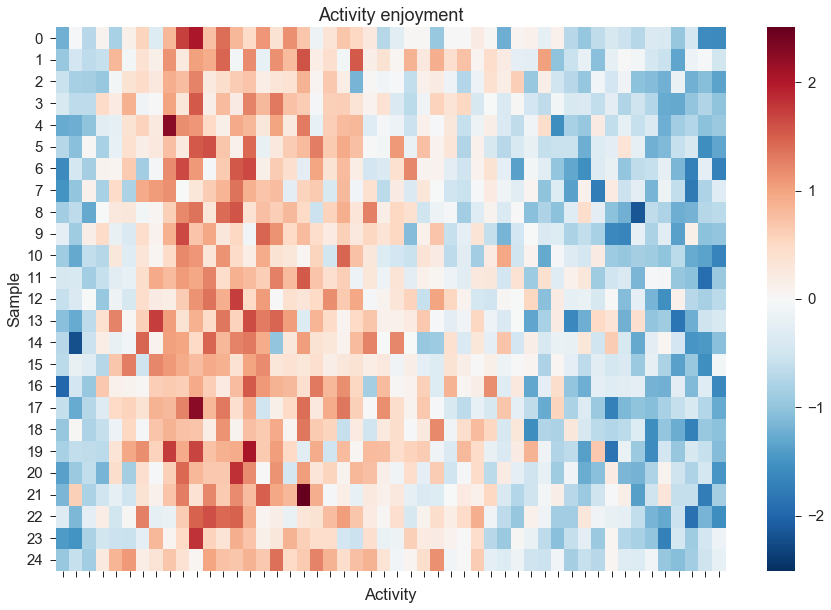

In [26]:
samples = single_participant_population(25, trait_vectors[0], .5)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(samples)
plt.title("Activity enjoyment")
plt.xlabel("Activity")
plt.ylabel("Sample")
ax.set_xticklabels([''] * len(trait_a_true))
plt.yticks(rotation=0);

In [27]:
from scipy.stats import pearsonr

model_coefs, model_r2s = test_participants(trait_vectors, samples)
lower_bound, upper_bound = multivariate_noise_ceiling(samples, 2)
lower_bound_u, upper_bound_u = univariate_noise_ceiling(samples)
correlation_result = np.mean([pearsonr(trait_vectors[0], sample)[0] for sample in samples])
print(f"R^2 = {np.mean(model_r2s).round(3)}")
print(f"Multivariate lower bound: {np.round(lower_bound, 3)}")
print(f"Multivariate upper bound: {np.round(upper_bound, 3)}")
print()
print(f"Correlation result: {np.round(correlation_result, 3)}")
print(f"Univariate lower bound: {np.round(lower_bound_u, 3)}")
print(f"Univariate upper bound: {np.round(upper_bound_u, 3)}")

R^2 = 0.596
Multivariate lower bound: 0.578
Multivariate upper bound: 0.675

Correlation result: 0.767
Univariate lower bound: 0.756
Univariate upper bound: 0.778


The model performance for each analysis falls within its noise ceiling (although sometimes the multivariate result will be below the lower bound, as above). However, the univariate analysis and noise ceiling are higher than their multivariate counterparts. This suggests a multivariate model is inappropriate for the data (which is true).

## Conclusion

The multivariate noise ceiling behaves as one would expect a noise ceiling to behave.

Please contact me if you have any comments or questions!

## Acknowledgements

Thanks to Bruce Doré, Eshin Jolly, Mark Thornton, Sam Nastase, and Matteo Visconi di Oleggio Castello for helpful conversation and criticism.